Step 1 - Import python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None

Step 2 - Load and read your data file
- pyTCR accepts a single `.tsv` file that should contain all the samples.
  - The following cell attempts to detect whether you are running the notebook in a Google Colab cloud environment or in a local environment, and then loads the data at the specified path.
- The `filePath` variable in the following code cell should be changed to the location of your file. The following options are supported:
  1. A `filePath` from Google Drive (to run on a cloud environment)
  2. A `filePath` from your local computer (to run on a local environment, other cloud environments should work as expected)
- The `data_adapter` notebook can be used to convert the data into the correct format for pyTCR to read.

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

df.head()

,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,...,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 3 - Create the standardized format (column content and column names)

- Sample name (sample)
- Clone frequency (freq)
- Clone reads count (#count)
- CDR3 amino acid clonotype (cdr3aa)
- CDR3 nucleotide (cdr3nt)
- V gene (v)
- D gene (d)
- J gene (j)
- Optional fields (here we use hospitalization as the clinical feature)

In [3]:
# Select the columns that are listed above
df = df[['sample','frequency', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', 'freq' , '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

df.head()

,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalized
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True


Clonal proportion

In [4]:
# Create an empty dataframe for storing results
df_clonal_portion = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])


for sample in samples:

    # Store the rows related to the sample 
    df_temp = df.loc[df['sample'] == sample]

    # Sort the sample clonotypes by frequency in descending order
    df_temp = df_temp.sort_values(by='freq', ascending=False)

    # Create a column to store the order
    df_temp['clonotype_number'] = np.arange(df_temp.shape[0])+1

    # Compute and store the cumulative sum of the frequencies
    df_temp['accum_freq'] = df_temp['freq'].cumsum()

    # Filter out accumulated frequencies smaller than 10% (10% can be adjusted by the user)
    df_temp = df_temp.loc[(df_temp['accum_freq']>=0) & (df_temp['accum_freq']<=0.1)]

    # Select the smallest accumulated frequency record and stores in the result dataframe
    df_temp = df_temp.sort_values(by='accum_freq', ascending=False)
    df_temp = df_temp.head(1)  
    df_clonal_portion = pd.concat([df_clonal_portion, df_temp],sort=True)

    # Show the results 
    df_clonal_portion = df_clonal_portion[['sample','hospitalized','clonotype_number']]

df_clonal_portion.columns = ['sample', 'hospitalized', 'clonality_portion']

## FigureS2a - violin plot

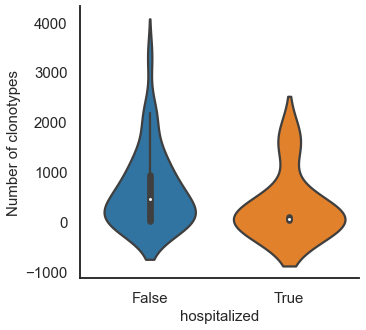

In [5]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.violinplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2a.png",bbox_inches="tight")

plt.show()

## FigureS2b - strip plot

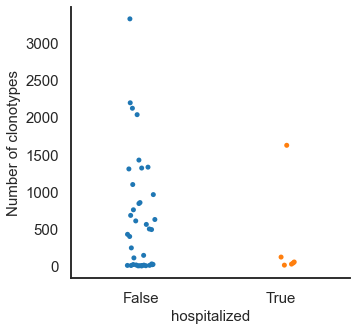

In [7]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.stripplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2b.png",bbox_inches="tight")

plt.show()

## FigureS2c - swarm plot

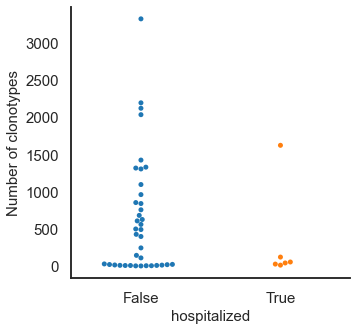

In [8]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.swarmplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2c.png",bbox_inches="tight")

plt.show()

## FigureS2d - box plot

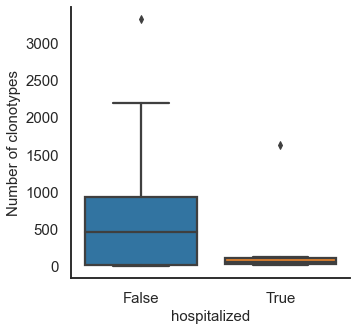

In [9]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2d.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2d.png",bbox_inches="tight")

plt.show()

## FigureS2e - boxen plot

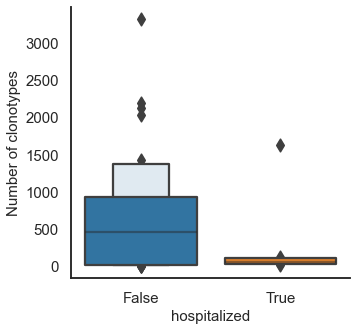

In [10]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxenplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2e.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2e.png",bbox_inches="tight")

plt.show()

## FigureS2f - point plot

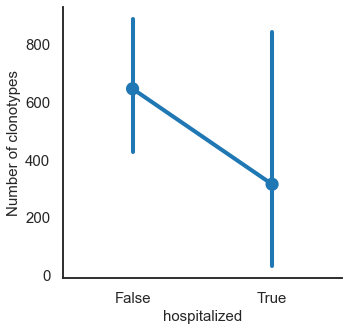

In [11]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.pointplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2f.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2f.png",bbox_inches="tight")

plt.show()

## FigureS2g - bar plot

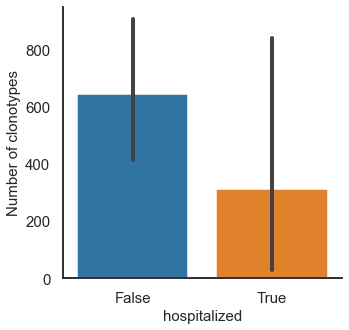

In [12]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.barplot(x=attribute, y='clonality_portion', data=df_clonal_portion)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Number of clonotypes', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS2g.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS2g.png",bbox_inches="tight")

plt.show()